### Basic imports

In [1]:
import pandas as pd
import sqlalchemy as sa
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))


### 1. Read in Data from csv --> could also use pd.read_sql and use .env to load auth info

In [2]:
loan_data = pd.read_csv("raw_data/loans_v2.csv")
# format date columns to datetime data types
date_cols = [c for c in loan_data.columns if str(c)[-2:]=='Dt']
for col in date_cols:
    loan_data[col] = pd.to_datetime(loan_data[col])

# loan_data.to_sql(name='loan_tape_fv', con=engine, if_exists='replace', index=False)

In [3]:
def subset_dataframe(df, conditions, inverse=False):
    """return a subset of a dataframe based on multiple columns and conditions"""
    if not inverse:
        mask = pd.Series(True, index=df.index)
        for col, cond in conditions.items():
            mask &= df[col].isin(cond)
    else:
        mask = pd.Series(True, index=df.index)
        for col, cond in conditions.items():
            mask &= ~df[col].isin(cond)
    return df[mask]

In [4]:
# Slice the data frame to only 21+ year maturity loans
data_slice = loan_data[loan_data['MatBucket']=='21+']

### 2. Use pool.py to organize cohorts --> loans are split into yyyy.mm cohorts

In [5]:
test_slice  = loan_data[loan_data['MatBucket']=='21+']
test_slice = test_slice[test_slice['Note_Yr']<=2021]
# test_slice = test_slice[test_slice['CodeText'].notna()]
# test_slice[test_slice['CodeText'].str.contains('Hotels')]

In [6]:
data_slice = loan_data[loan_data['MatBucket']=='21+']
data_slice = data_slice[data_slice['Note_Yr']<=2021]

# data_slice = data_slice[data_slice['Note_Yr']>2010]

# fast_payers = [811192,721110]

# data_slice = data_slice[~data_slice['Code'].isin(fast_payers)]
# data_slice = data_slice[data_slice['LoanAmt']>2_000_000]
# # data_slice = data_slice[data_slice['LoanAmt']<=2_000_000]
# data_slice = data_slice[data_slice['Margin']>.02]
# # data_slice = data_slice[data_slice['Margin']<=.02]

# print(f"loan count: {data_slice.shape[0]}")






In [7]:
from pooler import pool

# Define a function to create static pools of Loans from the DataFrame
def create_pooler(in_df:pd.DataFrame)-> pool.Pooler:
    temp = in_df.set_index('GP')
    temp = temp.to_dict()
    loans_dict = {}
    for gp in temp['NoteDt'].keys():
        loans_dict[str(gp)] = pool.Loan(gp, pd.to_datetime(temp['NoteDt'][gp]))
        loans_dict[str(gp)].maturity_dt = temp['MaturityDt'][gp]
        loans_dict[str(gp)].maturity_mths_qty = temp['MaturityMthsQty'][gp]
        loans_dict[str(gp)].default_dt = temp['DefaultDt'][gp]
        loans_dict[str(gp)].default_mths_qty = temp['DefaultMthsQty'][gp]
        loans_dict[str(gp)].prepay_dt = temp['PrepayDt'][gp]
        loans_dict[str(gp)].prepay_mths_qty = temp['PrepayMthsQty'][gp]

    return pool.Pooler(loans_dict)

my_pooler = create_pooler(data_slice)
my_pooler.build_triangles_counts()

pool_dict = {}
for k, v in my_pooler.triangles.items():
    pool_dict[k] = dict(outstanding=v[0], prepayments=v[1], defaults=v[2])


### 3. Convert Pool dictionaries into Dataframe

In [8]:
# Create Pool Dataframe
df_pool = pd.DataFrame.from_dict( pool_dict, orient='index')
df_pool.index = [float(e) for e in df_pool.index.to_list()]
df_pool = df_pool.sort_index()


In [10]:
# Format array lengths
max_row_length = df_pool.shape[0]
count = -1
for i, row in df_pool.iterrows():
    count+=1
    for col in df_pool.columns:
        arr = row[col][:(max_row_length-count)].astype(float)
        padded_arr = np.pad(arr, (0, max_row_length - (max_row_length-count) ), mode='constant', constant_values=np.nan)
        df_pool.at[i,col] = padded_arr




In [ ]:
# Format array lengths
max_row_length = df_pool.shape[0]
count = -1
for i, row in df_pool.iterrows():
    count+=1
    for col in df_pool.columns:
        arr = row[col][:(max_row_length-count)].astype(float)
        padded_arr = np.pad(arr, (0, max_row_length - (max_row_length-count) ), mode='constant', constant_values=np.nan)
        df_pool.at[i,col] = padded_arr
    

### 4. Group into Annual cohorts and calculate SMM and CPR

### Reshape the Yearly cohorts data from Months on Book to Year on Book  
`[i,...........,n=MoB] ---> applymap(aggregate_method)`  
 
`[[i,...]`  
`[i,...]`  
`[i,...]`  
`[i,...]`  
`[i,...]...n_years=YoB]`

In [11]:

# First try here
# def aggregate_annual_sums(in_arr):
#     n_years = len(in_arr) // 12
#     arr_2d = in_arr[:n_years*12].reshape(n_years,12)
#     return np.nansum(arr_2d, axis=1)

def outstanding_annual_rundown(in_arr):
    return in_arr[::11]

def aggregate_annual_sums(in_arr):
    remainder = len(in_arr) % 11
    if remainder != 0:
        padding = np.zeros(11 - remainder)
        subsections = np.concatenate([in_arr, padding])
    else:
        subsections = in_arr
    subsections = np.split(subsections, len(subsections) // 11)
    return (np.sum(subsections, axis=1))

def aggregate_annual_averages(in_arr):
    n_years = len(in_arr) // 11
    arr_2d = in_arr[:n_years*11].reshape(n_years,11)
    return np.nanmean(arr_2d, axis=1)

def aggregate_annual_median(in_arr):
    n_years = len(in_arr) // 11
    arr_2d = in_arr[:n_years*11].reshape(n_years,11)
    return np.nanmedian(arr_2d, axis=1)




In [12]:
# This is where we start abstracting away from the Data --> you're now looking at Annual Cohorts grouped together
df_pool['Year'] = df_pool.index.astype(int)
# Filter out years without 12 months of history
vals = df_pool['Year'].value_counts().to_dict()

yr_range = []
for k, v in vals.items():
    if v == 12:
        yr_range.append(k)

df_pool = df_pool[df_pool['Year'].isin(yr_range)]

# Switch to year group
year_grouped = df_pool.groupby('Year')
year_grouped = year_grouped.agg(np.nansum)


In [13]:
year_grouped['outstanding'] = year_grouped['outstanding'].apply(outstanding_annual_rundown)
year_grouped[['prepayments','defaults']] = year_grouped[['prepayments','defaults']].applymap(aggregate_annual_sums)
year_grouped['cpr'] = (year_grouped['prepayments']+year_grouped['defaults'])/year_grouped['outstanding']
# year_grouped['cpr'] = (1-(1-year_grouped['smm'])**12)
def enforce_shape(in_df:pd.DataFrame)->pd.DataFrame:
    data = in_df.copy(deep=True)
    last_year = data.index.max()+1
    for i in range(len(data)):
        max_col = last_year - data.index[i]
        data.iloc[i,(max_col):] = np.NaN
    return data

def generate_lifetime(cpr_df:pd.DataFrame)-> pd.DataFrame:
    # get the cumulative sum of each row WHILE ignoring NaN values (otherwise the denominator is off)
    cumulative_sum = np.nancumsum(cpr_df.values, axis=1)
    # compute the number of non-NaN values in each row
    num_non_nan = (~np.isnan(cpr_df.values)).cumsum(axis=1)
    # get ROW-WISE average up until the first NaN value is encountered
    row_avg = np.where(np.isnan(cpr_df), np.nan, cumulative_sum / num_non_nan)
    # create new dataframe with row-wise averages
    lifetime_df = pd.DataFrame(row_avg, columns=cpr_df.columns, index=cpr_df.index)
    return lifetime_df

cpr_heat = pd.DataFrame.from_dict(year_grouped['cpr'].to_dict(), orient='index')

cpr_heat = enforce_shape(cpr_heat)
lifetime_cprs = generate_lifetime(cpr_heat)
totals = year_grouped[['outstanding']].to_dict()
prepays = year_grouped[['prepayments']].to_dict()
defaults = year_grouped[['defaults']].to_dict()
totals = totals['outstanding']
prepays = prepays['prepayments']
defaults = defaults['defaults']
totals = (pd.DataFrame.from_dict(totals, orient='index'))
prepays = (pd.DataFrame.from_dict(prepays, orient='index'))
defaults = (pd.DataFrame.from_dict(defaults, orient='index'))
totals = enforce_shape(totals)
prepays = enforce_shape(prepays)
defaults = enforce_shape(defaults)
triangles = [totals,prepays,defaults]
totals = pd.concat(triangles,axis=0)
min_max_median = pd.DataFrame.from_dict({'max': cpr_heat.max(axis=0), 'median': cpr_heat.median(axis=0), 'avg': cpr_heat.mean(axis=0),\
                                          'min': cpr_heat.min(axis=0)}).transpose()
cpr_heat.to_csv('manual_outputs/cpr_heat.csv')
lifetime_cprs.to_csv('manual_outputs/lifetime.csv')
min_max_median.to_csv('manual_outputs/min_max_mids.csv')
totals.to_csv('manual_outputs/totals.csv')

### 5. Create basic triangles

### 6. Get Line Plots (or just the data for line plots)

In [14]:
def generate_lifetime(cpr_df:pd.DataFrame)-> pd.DataFrame:
    # get the cumulative sum of each row WHILE ignoring NaN values (otherwise the denominator is off)
    cumulative_sum = np.nancumsum(cpr_df.values, axis=1)
    # compute the number of non-NaN values in each row
    num_non_nan = (~np.isnan(cpr_df.values)).cumsum(axis=1)
    # get ROW-WISE average up until the first NaN value is encountered
    row_avg = np.where(np.isnan(cpr_df), np.nan, cumulative_sum / num_non_nan)
    # create new dataframe with row-wise averages
    lifetime_df = pd.DataFrame(row_avg, columns=cpr_df.columns, index=cpr_df.index)
    return lifetime_df

lifetime_cprs = generate_lifetime(cpr_heat)

lifetime_cprs.fillna('')


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2000,0.031383,0.06565,0.085646,0.100157,0.109841,0.127114,0.142303,0.154425,0.154917,0.148302,...,0.126081,0.123756,0.122113,0.121002,0.12141,0.120512,0.120791,0.12159,,
2001,0.014441,0.036166,0.060657,0.086014,0.113035,0.139172,0.149081,0.152845,0.147066,0.138944,...,0.121076,0.119963,0.119003,0.11834,0.118549,0.118905,0.117856,,,
2002,0.013593,0.03302,0.05819,0.113036,0.152175,0.177357,0.176413,0.165859,0.154659,0.145555,...,0.12886,0.127824,0.128326,0.127426,0.128587,0.130188,,,,
2003,0.013519,0.037698,0.089615,0.148098,0.172433,0.174343,0.161398,0.14986,0.142609,0.13663,...,0.125487,0.125533,0.125433,0.124888,0.12354,,,,,
2004,0.018899,0.056655,0.11561,0.157537,0.159477,0.149164,0.140231,0.133087,0.128817,0.125719,...,0.121565,0.122181,0.123689,0.1226,,,,,,
2005,0.017275,0.062142,0.098433,0.112486,0.109722,0.103771,0.099043,0.096566,0.097581,0.096949,...,0.103179,0.105399,0.105846,,,,,,,
2006,0.024050,0.057391,0.078811,0.086107,0.086653,0.088173,0.08839,0.089134,0.089004,0.088733,...,0.101677,0.102113,,,,,,,,
2007,0.017332,0.046769,0.061679,0.070744,0.074265,0.079647,0.08045,0.079612,0.081524,0.08261,...,0.094654,,,,,,,,,
2008,0.016204,0.037244,0.046805,0.052568,0.058702,0.064332,0.069434,0.074199,0.077156,0.08078,...,,,,,,,,,,
2009,0.006869,0.015292,0.023578,0.043958,0.058025,0.066462,0.07367,0.08425,0.090135,0.098189,...,,,,,,,,,,


In [15]:
import plotly.express as px

fig = px.line(lifetime_cprs.transpose(), line_shape= 'spline', title="Lifetime Average CPR by Year from Origination", markers=True)
fig.update_layout(yaxis_title='CPR', xaxis_title= 'Year from Origination', yaxis=dict(tickformat='0.0%'))

In [43]:
cprs = pd.read_csv('CPR_assembly_outputs/21+/baseline/cpr_heat.csv')
b_curve = pd.read_csv('CPR_assembly_outputs/21+/baseline/min_max_mids.csv')

b_curve = b_curve.iloc[1,:].values[1:]

s_curve = cprs[cprs.columns[1:]].std(axis=0)

temp = pd.DataFrame(dict(median= b_curve, std=s_curve))
temp['median'] = temp['median'].fillna(temp['median'].mean())
temp['std'] = temp['std'].fillna(temp['std'].mean())

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

b_curve = temp['median'].values
s_curve = temp['std'].values



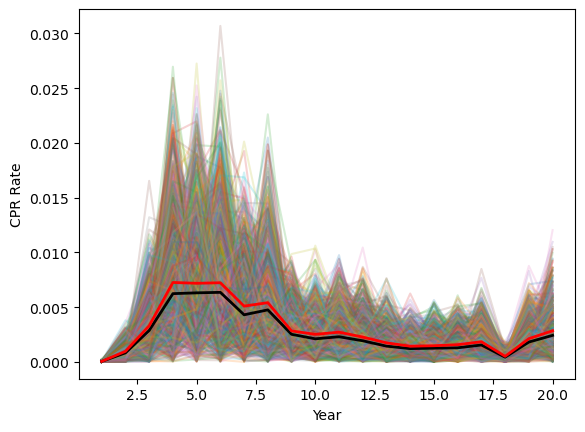

In [54]:

num_iterations = 1000

simulated_cpr_rates_all = np.zeros((num_iterations, b_curve.shape[0]))

for i in range(num_iterations):
    lower, upper = 0, np.inf
    mu, sigma = 0, s_curve
    X = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    random_numbers = X.rvs(size=b_curve.shape[0])

    sim_cprs = b_curve * (1-np.exp(-random_numbers))
    simulated_cpr_rates_all[i,:] = sim_cprs


# Calculate the median and average of the simulated CPR rates across all iterations
median_cpr_rates = np.median(simulated_cpr_rates_all, axis=0)
average_cpr_rates = np.mean(simulated_cpr_rates_all, axis=0)


plt.plot(np.arange(1, 21), simulated_cpr_rates_all[:,:20].T, alpha=0.2)
# Add a legend and axis labels
# Add a line plot of the median and average CPR rates
plt.plot(np.arange(1, 21), median_cpr_rates[:20], label='Median', lw=2, color='black')
plt.plot(np.arange(1, 21), average_cpr_rates[:20], label='Average', lw=2, color='red')

plt.xlabel('Year')
plt.ylabel('CPR Rate')

plt.show()